# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from  sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Read files

In [ ]:
# Load files into a pandas dataframe
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')
ss = pd.read_csv('./data/SampleSubmission.csv')

### Some basic EDA

In [ ]:
# Preview the first five rows of the train set
train.head()

In [ ]:
# Preview the first five rows of the test set
test.head()

In [ ]:
# Preview the first five rows of the sample submission file
ss.head()

In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

In [ ]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
train[train['Age'] < 18]. count()

In [ ]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 

In [ ]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

In [ ]:
# Preview the last five rows of the combined dataframe
all_data.tail()

In [ ]:
# Check the column names and datatypes
all_data.info()

In [ ]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

### Distribution of the target variable

In [ ]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

In [ ]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

### Number of unique values per categorical column

In [ ]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

### Filling in missing values
#### Missing values can be filled using different strategies
Tips:
 - Mean
 - Max
 - Min
 - [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
 - Others... do more reasearch

In [ ]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(50))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

### Feature Engineering
#### Alot of features can be extracted from dates
Tips:
 - Quarter, Start of Year, month?
 - Is it a weekend, weekday?
 - Is it a holiday
 - Duration between different periods, e.g start and end of a policy
 - What features can be derived from the age column
 - Be creative 😉

In [ ]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [ ]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

In [ ]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [ ]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(date_cols+['ID', 'target'])
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

#### [More on F1 Score](https://en.wikipedia.org/wiki/F-score)

### Making predictions of the test set and creating a submission file

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************

Train data preview:
           ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_0040R73        2010-05-14      2011-05-13    Male   30   
1  ID_0046BNK        2010-11-29      2011-11-28  Female   79   
2  ID_005QMC3        2010-03-21      2011-03-20    Male   43   
3  ID_0079OHW        2010-08-21      2011-08-20    Male    2   
4  ID_00BRP63        2010-08-29      2010-12-31  Entity   20   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-05-14       1       Saloon              Black   
1             2010-11-29       1         JEEP               Grey   
2             2010-03-21       1       Saloon                Red   
3             2010-08-21       1          NaN                NaN   
4             2010-08-29       3          NaN                NaN   

  Subject_Car_Make LGA_Name  State  ProductName  target  
0           TOYOTA      NaN    NaN  Car Classic       0  
1           TOYOTA      NaN    NaN  Car Classic       1  
2           

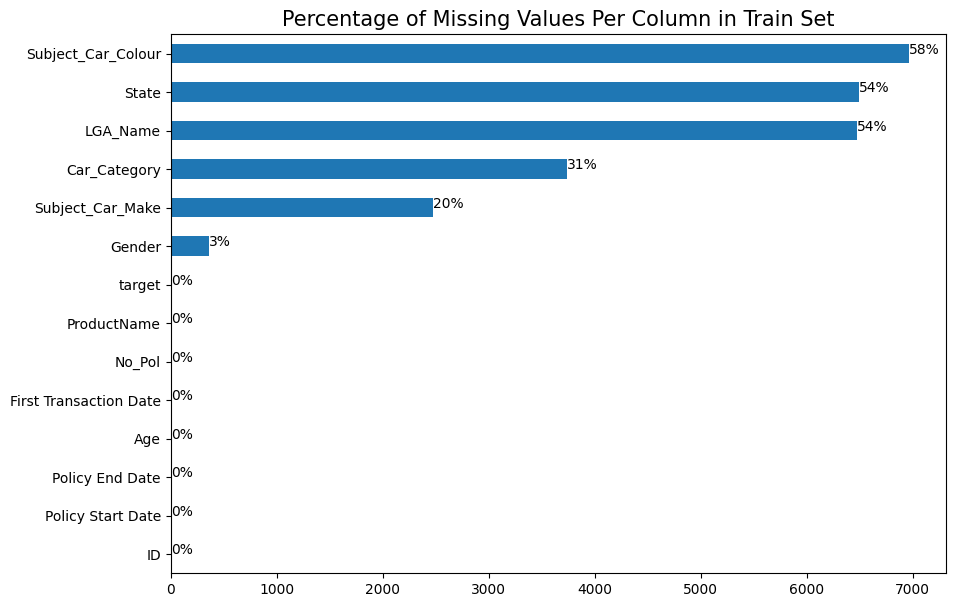

Minors in dataset: ID                        556
Policy Start Date         556
Policy End Date           556
Gender                    534
Age                       556
First Transaction Date    556
No_Pol                    556
Car_Category              356
Subject_Car_Colour        169
Subject_Car_Make          429
LGA_Name                  225
State                     225
ProductName               556
target                    556
dtype: int64


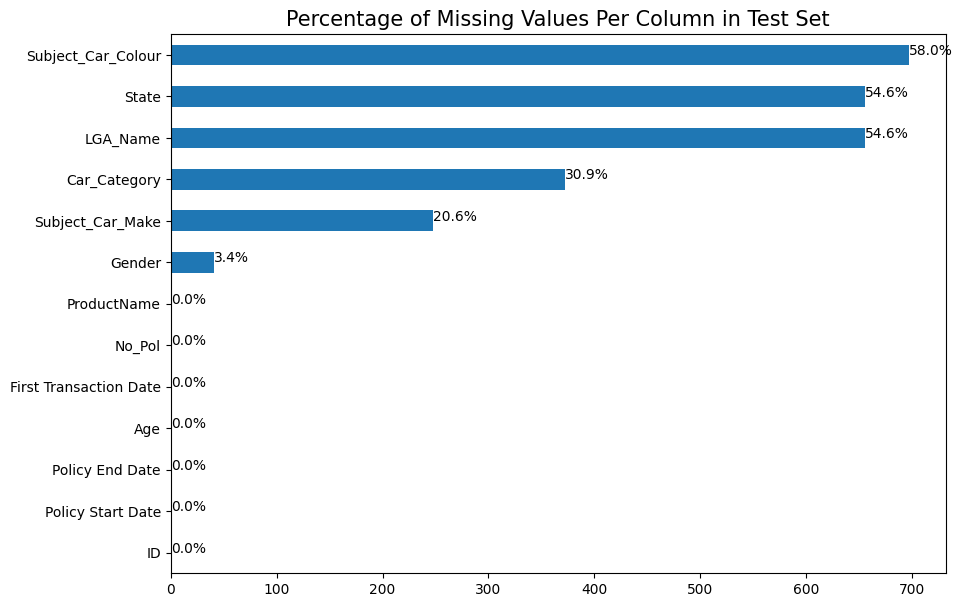

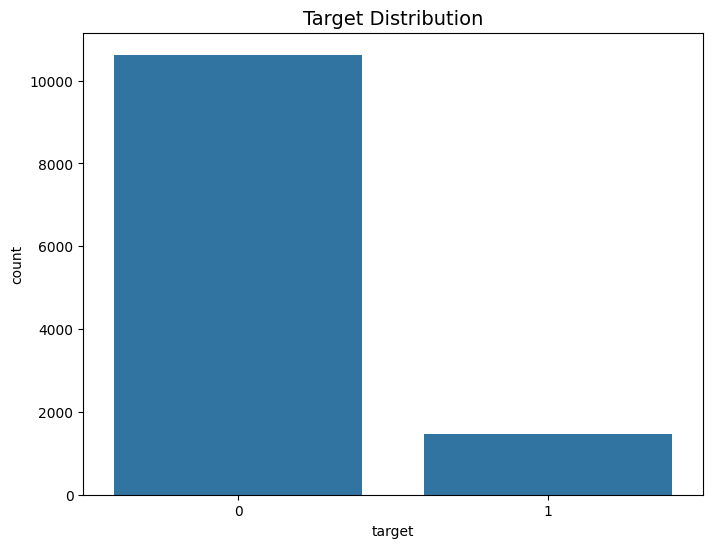

The shape of the combined dataframe is: (13281, 14)
Missing values after preprocessing:
0
1202
Validation F1 Score: 0.0568
Validation Precision: 0.7222
Validation Recall: 0.0295
Validation Confusion Matrix:
[[3179    5]
 [ 427   13]]


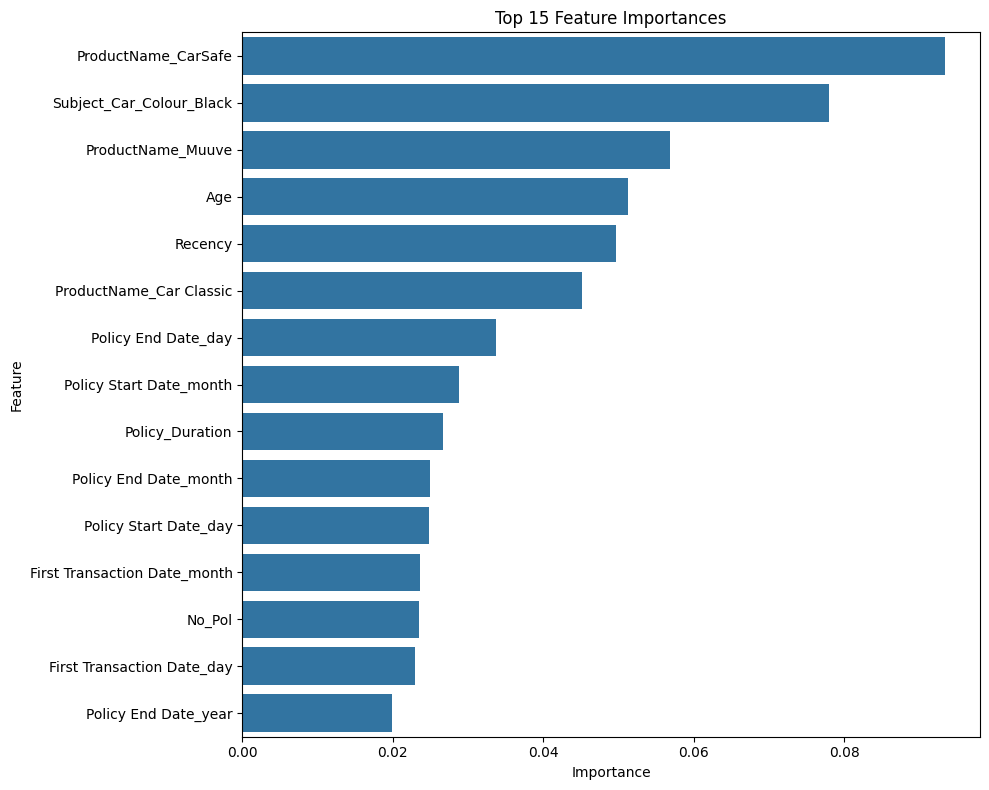

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- target


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load files into a pandas dataframe
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')
sample_submission = pd.read_csv('./data/SampleSubmission.csv')

## Exploratory Data Analysis
print("Train data preview:")
print(train.head())
print("\nTest data preview:")
print(test.head())
print("\nSample submission preview:")
print(sample_submission.head())

# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

# Check if there any missing values in train set
plt.figure(figsize=(10, 7))
ax = train.isna().sum().sort_values().plot(kind='barh')
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage, (x, y))
plt.show()

# Check minors in dataset
print(f"Minors in dataset: {train[train['Age'] < 18].count()}")

# Check if there are missing values in test set
plt.figure(figsize=(10, 7))
ax = test.isna().sum().sort_values().plot(kind='barh')
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage, (x, y))
plt.show()

# Target distribution visualization
plt.figure(figsize=(8, 6))
sns.countplot(x=train.target)
plt.title('Target Distribution', fontdict={'size':14})
plt.show()

## Data Preprocessing and Feature Engineering using the combined approach
# Store train size for later splitting
ntrain = train.shape[0]

# Combine train and test set for easier preprocessing
all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

# Identify column types
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols + num_cols + ['ID', 'target']]

# Convert columns to appropriate data types
for col in all_data.columns:
    if col in date_cols:
        all_data[col] = pd.to_datetime(all_data[col])
    elif col in cat_cols:
        all_data[col] = all_data[col].astype('category')

# Handle Gender categories - group less frequent categories
gender_mapping = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 
                 'NO GENDER': 'Other', 'SEX':"Other"}
all_data['Gender'] = all_data['Gender'].replace(gender_mapping)

# Fill in missing values 
for col in all_data.columns:
    if col in cat_cols:
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    elif col in num_cols:
        # Use mean for Age and fill with 50 if needed
        if col == 'Age':
            # Clean Age values first
            all_data[col] = all_data[col].apply(lambda x: np.nan if x < 0 or x > 100 else x)
            all_data[col] = all_data[col].fillna(all_data[col].mean())
        else:
            all_data[col] = all_data[col].fillna(all_data[col].median())

# Feature Engineering

# 1. Extract date features
for col in date_cols:
    for date_feature in ['year', 'month', 'day']:
        all_data[f'{col}_{date_feature}'] = getattr(all_data[col].dt, date_feature)
    
    # Add weekday feature
    all_data[f'{col}_weekday'] = all_data[col].dt.weekday

# 2. Policy Duration and Customer Tenure (from your original code)
all_data['Policy_Duration'] = (all_data['Policy End Date'] - all_data['Policy Start Date']).dt.days
all_data['Customer_Tenure'] = (all_data['Policy Start Date'] - all_data['First Transaction Date']).dt.days

# 3. Calculate Recency (days since policy ended)
today = pd.Timestamp.today()
all_data['Recency'] = (today - all_data['Policy End Date']).dt.days

# One-hot encode categorical variables
all_data = pd.get_dummies(data=all_data, columns=cat_cols, drop_first=True)

# Drop the original date columns as we've extracted features from them
all_data = all_data.drop(columns=date_cols)

# Split back into train and test
train_processed = all_data[:ntrain].copy()
test_processed = all_data[ntrain:].copy()

# Check for any remaining missing values
print("Missing values after preprocessing:")
print(train_processed.isnull().sum().sum())
print(test_processed.isnull().sum().sum())

# Standardize numerical features
scaler = StandardScaler()
num_features = ['Age', 'No_Pol', 'Policy_Duration', 'Customer_Tenure', 'Recency'] + \
               [col for col in train_processed.columns if any(x in col for x in ['year', 'month', 'day', 'weekday'])]

# Only scale columns that exist in the dataframe
num_features = [col for col in num_features if col in train_processed.columns]
train_processed[num_features] = scaler.fit_transform(train_processed[num_features])
test_processed[num_features] = scaler.transform(test_processed[num_features])

# Prepare training data
X = train_processed.drop(columns=['ID', 'target'])
y = train_processed['target']
X_test = test_processed.drop(columns=['ID'])

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluate on validation set
val_predictions = model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions)
val_precision = precision_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_conf_matrix = confusion_matrix(y_val, val_predictions)

print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print("Validation Confusion Matrix:")
print(val_conf_matrix)

# Feature importance analysis
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Make predictions on test set
test_predictions = model.predict(X_test)

# Create submission file
sample_submission['target'] = test_predictions
sample_submission.to_csv('submission_test.csv', index=False)

# Show distribution of predictions
plt.figure(figsize=(8, 6))
sns.countplot(x=test_predictions)
plt.title('Test Predictions Distribution')
plt.show()

print("Submission file created: submission.csv")